In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()
printer = PrintHelper()

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_25_01_m3_convex\models.txt


In [29]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold, _debug_print=False):    
    if _debug_print:
        print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'@default_class': 1.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model
def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold, _debug_print=False):
    if _debug_print:
        print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='ss_phi_score', class_id='@default_class'))
    artm_model.scores.add(artm.SparsityThetaScore(name='ss_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='@default_class', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@default_class', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name='', _debug_print=False): 
    if _debug_print:
        print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    if _debug_print:
        print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [31]:
def calculate_distances(dist_fun, _phi, _phi_other, _debug_print=False):
    if _debug_print:
        print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        if _debug_print and idx % 20 == 0:
            print '[{}] column {} / {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def get_optimization_result_one_matrix(dist_fn, jac_dist_fn, phi, distances, _debug_print=False):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if _debug_print and col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))
        column = phi[col_name]
        # delete col from phi
        phi_cut = phi.drop(col_name, axis=1)
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_cut, distances)
    return opt_results
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if _debug_print and col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))        
        column = phi[col_name]
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi, distances, verbose=False):
    max_iter = 50
    phi_columns = phi.columns
    # cut distances by phi columns 
    cut_distances = distances[phi_columns]
    # get n closest topics
    closest_column_names = cut_distances.loc[column_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_column_names]
    
    # opt solver
    n_columns = phi_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(column, phi_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(column, phi_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    if not is_optimized:
        print 'Not optimized'         
    res['column_names'] = phi_closest.columns
    res['optimized_column'] = column_name
    res['projection'] = phi_closest.dot(res.x)
    res['column'] = column
    return res

Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [9]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model3', 'distances_hellinger_model3', config.output_batches_path)
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


Запустить несколько раз с разным рандомом. Следить за тем, чтобы накапливались только независимые темы. Каждый раз смотреть. как проектируется на оригинальную матрицу.

In [33]:
N_CLOSEST_TOPICS = 10
def create_model_fn_1(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m1_iter_{}'.format(n_iteration))
    return tmp_model
def filter_convex_hull(phi_convex_hull, get_topics_to_remove_fn, max_iteration=5):
    distances_model_iter = calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_convex_hull)
    iterations_info = []
    for n_iteration in range(max_iteration):
        print('[{}] iteration = {} / {}'.format(datetime.now(), n_iteration, max_iteration))
        # get new opts results
        opt_res_convex_hull_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, 
                                                                       phi_convex_hull, distances_model_iter)
        # get topics to remove
        topics_to_remove, not_removed_topics_count = get_topics_to_remove_fn(opt_res_convex_hull_inter, distances_model_iter)
        # update phi convex
        phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove)
        distances_model_iter = remove_topics_from_distances_xy(distances_model_iter, topics_to_remove)
        iterations_info.append({'it': n_iteration,
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count,
                                'phi_convex_hull': phi_convex_hull, 
                                'opt_res': opt_res_convex_hull_inter})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], not_removed_topics_count, iterations_info[-1]['phi_convex_hull_shape']))
        if len(iterations_info) > 3 and iterations_info[-1]['n_topics_to_remove'] == 0 and iterations_info[-2]['n_topics_to_remove'] == 0:
            print('[{}] topics to remove not increasing, breaking the for loop'.format(datetime.now()))
            break
    return phi_convex_hull, iterations_info
def build_convex_hull(create_model_fn, get_topics_to_remove_fn, words,
                      init_convex_hull, start_iteration, max_iteration):
    # init phi of convex hull
    phi_convex_hull = init_convex_hull
    if len(phi_convex_hull) == 0:
        phi_convex_hull = pd.DataFrame(0, index = words, columns=[])
    iterations_info = []
    for n_iteration in range(start_iteration, start_iteration + max_iteration):
        print('[{}] iteration = {} / {}'.format(datetime.now(), n_iteration, start_iteration + max_iteration))
        # build model
        model = create_model_fn(n_iteration)
        phi = model.get_phi()
        # rename phi columns 
        phi.columns = [c + '_{}'.format(n_iteration) for c in phi.columns]
        # add to convex hull
        phi_convex_hull_expanded = pd.concat([phi_convex_hull, phi], axis=1)
        # get new opts results
        distances_model_iter = calculate_distances(dh.hellinger_dist, phi_convex_hull_expanded, phi_convex_hull_expanded)
        opt_res_convex_hull_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, 
                                                                       phi_convex_hull_expanded, distances_model_iter)
        # get topics to remove
        topics_to_remove, not_removed_topics_count = get_topics_to_remove_fn(opt_res_convex_hull_inter, distances_model_iter)
        # update phi convex
        phi_convex_hull = remove_topics_from_phi(phi_convex_hull_expanded, topics_to_remove)
        iterations_info.append({'it': n_iteration,
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count,
                                'phi_convex_hull': phi_convex_hull, 
                                'opt_res': opt_res_convex_hull_inter})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], 
               iterations_info[-1]['not_removed_topics_count'],
               iterations_info[-1]['phi_convex_hull_shape']))
    return phi_convex_hull, iterations_info
def build_convex_hull_2(create_model_fn, get_topics_to_remove_fn, words,
                      init_convex_hull, start_iteration, max_iteration):
    # init phi of convex hull
    phi_convex_hull = init_convex_hull
    if len(phi_convex_hull) == 0:
        phi_convex_hull = pd.DataFrame(0, index = words, columns=[])
    iterations_info = []
    for n_iteration in range(start_iteration, start_iteration + max_iteration):
        print('[{}] iteration = {} / {}'.format(datetime.now(), n_iteration, start_iteration + max_iteration))
        # build model
        model = create_model_fn(n_iteration)
        phi = model.get_phi()
        # rename phi columns 
        phi.columns = [c + '_{}'.format(n_iteration) for c in phi.columns]
        # add to convex hull
        phi_convex_hull_expanded = pd.concat([phi_convex_hull, phi], axis=1)
        # filter topics 
        phi_convex_hull, iterations_info_filter = filter_convex_hull(phi_convex_hull_expanded, get_topics_to_remove_fn,
                                                                     max_iteration=15)
        iterations_info.append({'it': n_iteration,
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count,
                                'iterations_info_filter': iterations_info_filter,
                                'phi_convex_hull': phi_convex_hull, 
                                'opt_res': opt_res_convex_hull_inter})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], 
               iterations_info[-1]['not_removed_topics_count'],
               iterations_info[-1]['phi_convex_hull_shape']))
    return phi_convex_hull, iterations_info
def get_topics_to_remove_by_opt_fun_and_distance(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt['fun'])
    topics_to_remove = []
    not_removed_count = 0 
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_close_fn = lambda topic, other_topic: other_topic in distances[topic].sort_values().head(n_closest).index
        is_close_to_topics_to_remove = [is_close_fn(topic_name, t) for t in topics_to_remove]
        is_close_to_topics_to_remove = True in is_close_to_topics_to_remove 
        if not is_close_to_topics_to_remove:
            topics_to_remove.append(topic_name)
        else:
            not_removed_count += 1 
    return topics_to_remove, not_removed_count
def get_topics_to_remove_by_opt_fun(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    topics_to_remove = [x['optimized_column'] for x in small_dist_opts.values()]
    not_removed_count = 0
    return topics_to_remove, not_removed_count
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances_x(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=0)
    return distances_convex_hull
def remove_topics_from_distances_xy(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull

In [32]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull, iterations_info = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

[2017-01-29 22:56:49.729000] iteration = 0 / 50
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 22:57:19.783000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-01-29 22:57:19.783000] iteration = 1 / 50
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 22:57:56.480000] 36 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 4)
[2017-01-29 22:57:56.481000] iteration = 2 / 50
name = model_20_m1_iter_2, n_topics = 20, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 22:58:28.715000] 1 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 23)
[2017-01-29 22:58:28.715000] iteratio

In [ ]:
OPT_FUN_THRESHOLD = 0.2
phi_convex_hull_1, iterations_info_1 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

[2017-01-29 23:32:23.095000] iteration = 0 / 50
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 23:32:49.895000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-01-29 23:32:49.895000] iteration = 1 / 50
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 23:33:22.115000] 2 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 38)
[2017-01-29 23:33:22.115000] iteration = 2 / 50
name = model_20_m1_iter_2, n_topics = 20, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 23:33:58.544000] 3 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 55)
[2017-01-29 23:33:58.544000] iteratio

In [ ]:
OPT_FUN_THRESHOLD = 0.3
phi_convex_hull_2, iterations_info_2 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.4
phi_convex_hull_3, iterations_info_3 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.5
phi_convex_hull_4, iterations_info_4 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.5
N_CLOSEST_TOPICS = 10
phi_convex_hull_5, iterations_info_5 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.5
N_CLOSEST_TOPICS = 15
phi_convex_hull_6, iterations_info_6 = build_convex_hull(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.2
phi_convex_hull_7, iterations_info_7 = build_convex_hull_2(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.3
phi_convex_hull_8, iterations_info_8 = build_convex_hull_2(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.4
phi_convex_hull_9, iterations_info_9 = build_convex_hull_2(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

In [ ]:
OPT_FUN_THRESHOLD = 0.5
phi_convex_hull_10, iterations_info_10 = build_convex_hull_2(create_model_fn_1, get_topics_to_remove_by_opt_fun, phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)

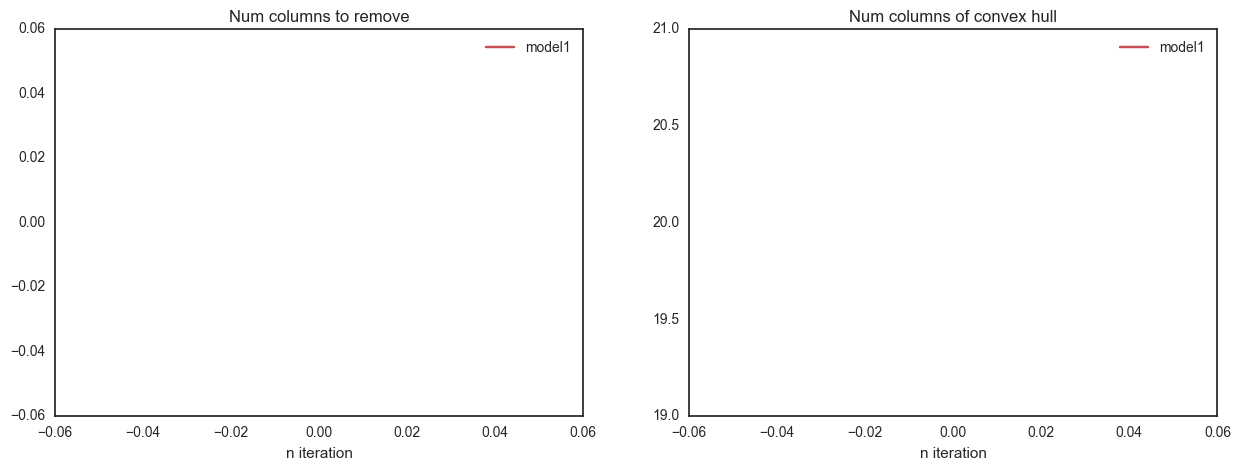

In [22]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
ax1.plot([val['n_topics_to_remove'] for val in iterations_info], color='r', label='model1')
ax1.set_title('Num columns to remove')
ax1.set_xlabel('n iteration')
ax1.legend()

ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r', label='model1')
ax2.set_title('Num columns of convex hull')
ax2.set_xlabel('n iteration')
ax2.legend()

get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
n_topics_removed_from_current_iteration = [[get_topic_iteration_fn(t) for t in it['removed_topics']].count(indx) for indx, it in enumerate(iterations_info)]
ax1.plot(n_topics_removed_from_current_iteration, color='b')


In [244]:
filtered_phi_convex_hull, filtered_iterations_info = filter_convex_hull(phi_convex_hull.copy(), max_iteration=20)

[2017-01-29 20:33:09.297000] take_distances between 139 columns and 139 columns
[2017-01-29 20:33:09.301000] column 0 / 139
[2017-01-29 20:33:11.629000] column 20 / 139
[2017-01-29 20:33:13.710000] column 40 / 139
[2017-01-29 20:33:15.929000] column 60 / 139
[2017-01-29 20:33:18.057000] column 80 / 139
[2017-01-29 20:33:20.149000] column 100 / 139
[2017-01-29 20:33:22.247000] column 120 / 139
[2017-01-29 20:33:24.259000] iteration = 0 / 20
[2017-01-29 20:33:24.259000] get_optimization_result for column 0 / 139
[2017-01-29 20:33:26.885000] get_optimization_result for column 20 / 139
[2017-01-29 20:33:30.921000] get_optimization_result for column 40 / 139
[2017-01-29 20:33:33.839000] get_optimization_result for column 60 / 139
[2017-01-29 20:33:37.092000] get_optimization_result for column 80 / 139
[2017-01-29 20:33:39.808000] get_optimization_result for column 100 / 139
[2017-01-29 20:33:42.224000] get_optimization_result for column 120 / 139
[2017-01-29 20:33:44.958000] 20 topics to re

In [238]:
# to do : save phi_convex on each iteration,
# make plot each iteration , save it
# разобраться почему 
# заодно сразу стабильность мерить
# спроектировать конечный результат на оригинальную 


[0, 2, 4, 6, 4, 9, 8, 7, 12, 7, 8, 9, 10, 10, 11, 15, 13, 13, 11, 13, 11, 15, 9, 13, 15, 15, 7, 11, 16, 8, 12, 11, 11, 18, 6, 10, 12, 11, 12, 13, 17, 15, 16, 11, 15, 12, 15, 14, 13, 15]
